In [1]:
pip install -U imbalanced-learn

Could not fetch URL https://pypi.org/simple/imbalanced-learn/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/imbalanced-learn/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: EE certificate key too weak (_ssl.c:1007)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('dataset_textblob_unbalanced.csv', sep=';')
print(display(df.head()))
print(df['sentiment'].value_counts())

,text,sentiment
0,one asian face entire film unbelievable,negative
1,watching movie like make thing hard mind begin...,positive
2,matt damon musnash make look like creepy perv,negative
3,best movie ever,positive
4,went full nuclear man never go full nuclear al...,positive


None
sentiment
neutral     12567
positive    12068
negative     4641
Name: count, dtype: int64


In [4]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(df['text'])

2024-02-28 03:38:53.692840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 03:38:53.692865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 03:38:53.693454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 03:38:53.696816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 03:38:54.134711: W tensorflow/compiler/tf2

In [5]:
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index

In [6]:
from keras.preprocessing import sequence
MAX_SEQUENCE_LENGTH = 300
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [7]:
from gensim.models import FastText
fasttext_model = FastText.load('ftm_textblob_unbalanced.bin')

In [8]:
import numpy as np
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, 16))
for word, i in word_index.items():
    try:
        embedding_vector = fasttext_model.wv[word]
    except:
        print(f'word \"{word}\" is not found')
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

In [9]:
print(vocab_size)
print(embedding_matrix)

17872
[[ 0.90132523  0.72351302  0.22851191 ...  0.87812862  0.82294561
   0.7569375 ]
 [ 0.78475016 -1.10088122  1.43270242 ... -0.37279657 -0.73966998
  -1.32935405]
 [-0.63179493 -0.51473856  4.15192461 ...  1.06088805 -0.03148276
  -3.17906094]
 ...
 [ 0.28268966 -0.5065949   0.25281203 ...  0.12653306  0.29016528
  -0.87596071]
 [ 0.42388511  0.4323121   0.66387355 ... -0.57737881 -0.07690419
  -0.83667463]
 [-0.01019584 -0.02684091 -0.01469991 ... -0.00819485  0.0119387
  -0.04215815]]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
SPLIT_RATIO = 0.2
RANDOM_STATE = 27
X = df['text']
y = df['sentiment']
l_encode = LabelEncoder()
l_encode.fit(y)
X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, test_size=SPLIT_RATIO, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=SPLIT_RATIO, random_state=RANDOM_STATE)
print(X_train[:10])
print(y_train[:10])

[[   32    58    92 ...     0     0     0]
 [ 1092  1255 14833 ...     0     0     0]
 [  203     4     0 ...     0     0     0]
 ...
 [   28    98   590 ...     0     0     0]
 [   20   174  1296 ...     0     0     0]
 [   19  8585     0 ...     0     0     0]]
3799     positive
17801     neutral
9808      neutral
1256     negative
6234      neutral
16366     neutral
9528     positive
12029    positive
24079    positive
23145    negative
Name: sentiment, dtype: object


In [11]:
from imblearn.over_sampling import SMOTE

desired_samples = {
    'positive': 12567,
    'negative': 12567,
    'neutral': 12567
}

smt = SMOTE(sampling_strategy=desired_samples)
X_smote, y_smote = smt.fit_resample(X_train, y_train)

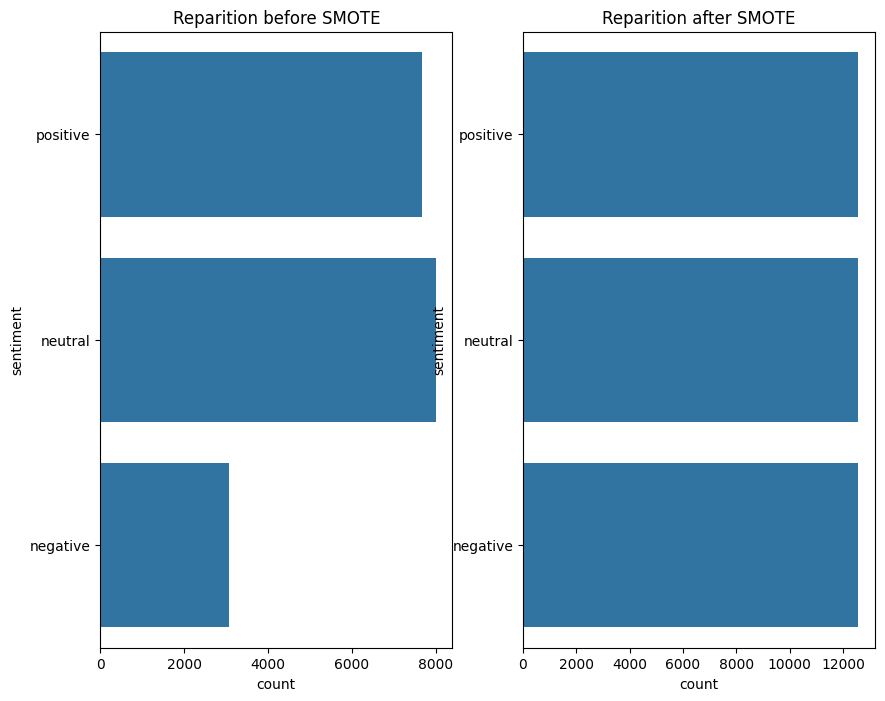

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after SMOTE')
plt.show()

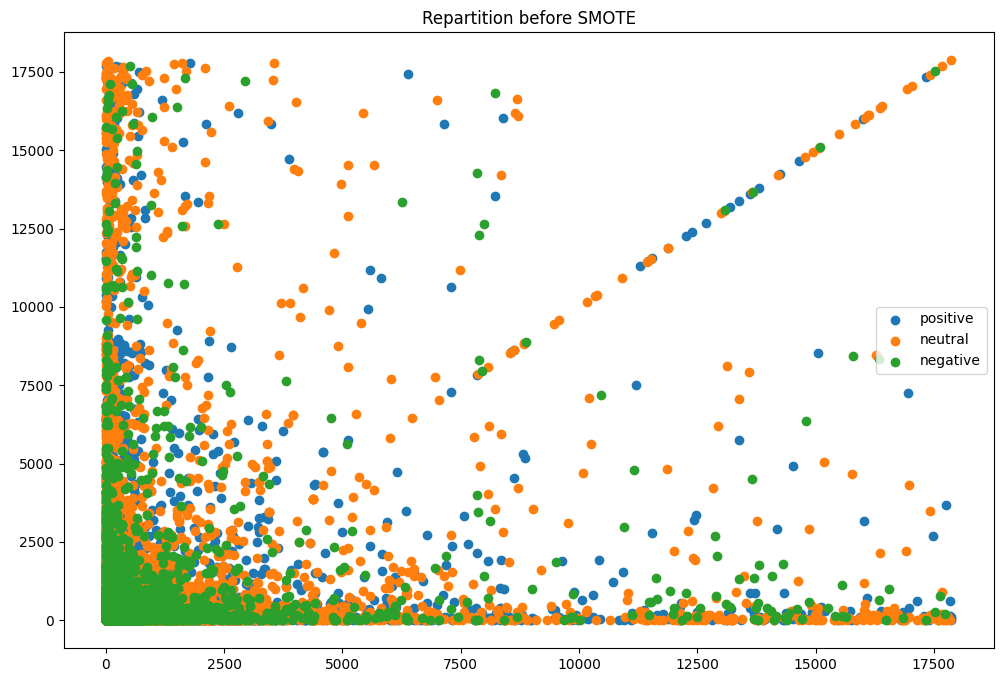

In [13]:
plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(X_train[y_train=='positive'][:, 0], X_train[y_train=='positive'][:, 1], label='positive')
plt.scatter(X_train[y_train=='neutral'][:, 0], X_train[y_train=='neutral'][:, 1], label='neutral')
plt.scatter(X_train[y_train=='negative'][:, 0], X_train[y_train=='negative'][:, 1], label='negative')

plt.legend()
plt.grid(False)
plt.show()

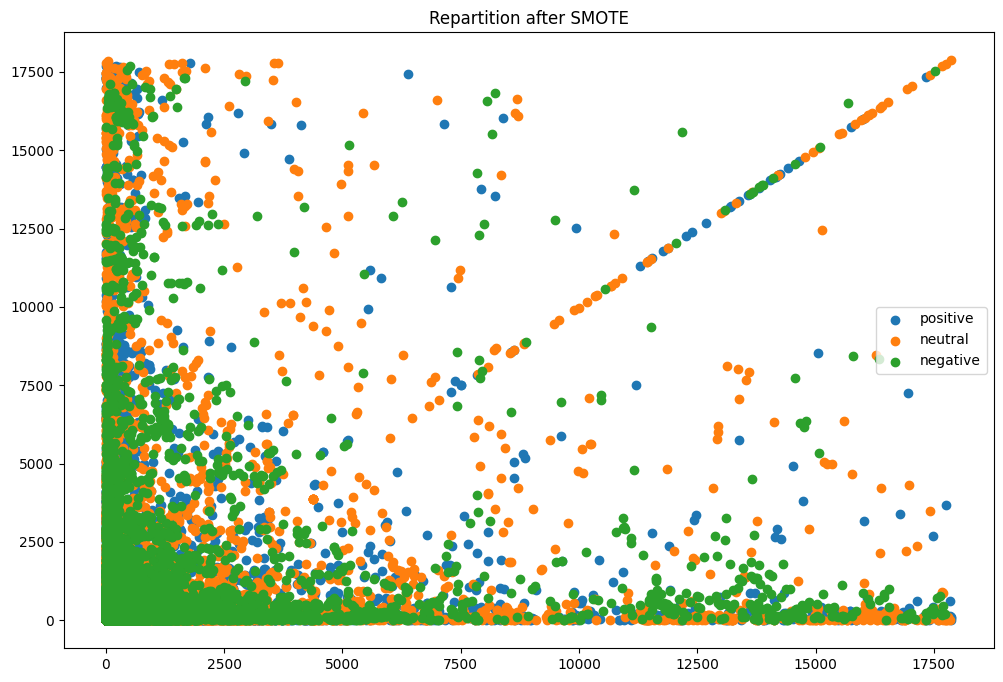

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Repartition after SMOTE')
plt.scatter(X_smote[y_smote=='positive'][:, 0], X_smote[y_smote=='positive'][:, 1], label='positive')
plt.scatter(X_smote[y_smote=='neutral'][:, 0], X_smote[y_smote=='neutral'][:, 1], label='neutral')
plt.scatter(X_smote[y_smote=='negative'][:, 0], X_smote[y_smote=='negative'][:, 1], label='negative')

plt.legend()
plt.grid(False)
plt.show()

In [15]:
y_train_cat = l_encode.transform(y_train)
y_train_cat = to_categorical(y_train_cat, num_classes=3)

In [16]:
y_val_cat = l_encode.transform(y_val)
y_val_cat = to_categorical(y_val_cat, num_classes=3)

In [17]:
y_test_cat = l_encode.transform(y_test)
y_test_cat = to_categorical(y_test_cat, num_classes=3)

In [18]:
y_smote_cat = l_encode.transform(y_smote)
y_smote_cat = to_categorical(y_smote_cat, num_classes=3)

In [19]:
print(y_train[:10])
print()
print(y_smote[:10])

3799     positive
17801     neutral
9808      neutral
1256     negative
6234      neutral
16366     neutral
9528     positive
12029    positive
24079    positive
23145    negative
Name: sentiment, dtype: object

0    positive
1     neutral
2     neutral
3    negative
4     neutral
5     neutral
6    positive
7    positive
8    positive
9    negative
Name: sentiment, dtype: object


In [20]:
print(y_train_cat[:10])
print()
print(y_smote_cat[:10])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [21]:
print(f'X_train: {len(X_train)}')
print(f'y_train: {len(y_train)}\n')

print(f'X_smote: {len(X_smote)}')
print(f'y_smote: {len(y_smote)}\n')

print(f'X_test: {len(X_test)}')
print(f'y_test: {len(y_test)}\n')

print(f'X_val: {len(X_val)}')
print(f'y_val: {len(y_val)}')

assert len(X_train) + len(X_test) + len(X_val) == len(X)

X_train: 18736
y_train: 18736

X_smote: 37701
y_smote: 37701

X_test: 5856
y_test: 5856

X_val: 4684
y_val: 4684


In [22]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, Embedding
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int64')
    
    embeddings = Embedding(input_dim=vocab_size, output_dim=16, weights=[embedding_matrix])(sentence_indices)
    
    X = Bidirectional(GRU(16, return_sequences=False))(embeddings)
    
    X = Dropout(rate=0.5)(X)
        
    X = Dense(3, activation='softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [24]:
model = build_model()
model.summary()

2024-02-28 03:39:34.260097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 03:39:34.284977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 03:39:34.285201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 16)           285952    
                                                                 
 bidirectional (Bidirection  (None, 32)                3264      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 289315 (1.10 MB)
Trainable params: 289315 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [25]:
from keras import backend as K

@keras.saving.register_keras_serializable()
def f1(y_true, y_pred):
    @keras.saving.register_keras_serializable()
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    @keras.saving.register_keras_serializable()
    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
import tensorflow as tf

@keras.saving.register_keras_serializable()
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [27]:
import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time_end = time.time()
        self.times.append(epoch_time_end - self.epoch_time_start)
        
time_callback = TimeHistory()

In [28]:
model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy', f1])
history = model.fit(X_smote, y_smote_cat, batch_size=256, epochs=200, validation_data=(X_val, y_val_cat), callbacks=[time_callback], shuffle=True)

Epoch 1/200


2024-02-28 03:39:52.760354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-02-28 03:39:53.205459: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe51e14ec90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 03:39:53.205474: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-28 03:39:53.208421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709066393.261030 1234140 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 19s 117ms/step - loss: 0.6146 - accuracy: 0.4130 - f1: 0.3489 - val_loss: 0.5468 - val_accuracy: 0.5325 - val_f1: 0.5227
Epoch 2/200
148/148 [==============================] - 13s 87ms/step - loss: 0.5177 - accuracy: 0.5090 - f1: 0.4993 - val_loss: 0.5052 - val_accuracy: 0.5497 - val_f1: 0.5487
Epoch 3/200
148/148 [==============================] - 9s 59ms/step - loss: 0.4862 - accuracy: 0.5339 - f1: 0.5306 - val_loss: 0.4797 - val_accuracy: 0.5805 - val_f1: 0.5789
Epoch 4/200
148/148 [==============================] - 8s 51ms/step - loss: 0.4673 - accuracy: 0.5486 - f1: 0.5470 - val_loss: 0.4595 - val_accuracy: 0.5999 - val_f1: 0.5981
Epoch 5/200
148/148 [==============================] - 7s 46ms/step - loss: 0.4551 - accuracy: 0.5586 - f1: 0.5570 - val_loss: 0.4454 - val_accuracy: 0.6074 - val_f1: 0.6061
Epoch 6/200
148/148 [==============================] - 6s 38ms/step - loss: 0.4384 - accuracy: 0.5754 - f1: 0.5751 - val_loss: 0.4305 - val

In [29]:
import matplotlib.pyplot as plt
def print_hist(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model af1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [30]:
print(time_callback.times)
print(sum(time_callback.times))

[19.461241006851196, 12.946903228759766, 8.783833742141724, 7.502874135971069, 6.7317445278167725, 5.538710117340088, 5.015197038650513, 4.881387948989868, 4.632858514785767, 4.451239585876465, 3.9638876914978027, 4.282116889953613, 4.585363864898682, 3.372511625289917, 3.752720594406128, 3.738123893737793, 3.894685745239258, 3.7971088886260986, 3.6242597103118896, 3.44659161567688, 4.115856409072876, 3.5866575241088867, 3.475616455078125, 3.622967481613159, 3.507132053375244, 3.616753578186035, 3.6442058086395264, 3.5435144901275635, 3.497558832168579, 3.512972354888916, 3.2357983589172363, 3.400712490081787, 3.5096023082733154, 3.2346994876861572, 3.429347276687622, 3.2392325401306152, 3.2650961875915527, 3.250321865081787, 3.2544174194335938, 3.4981751441955566, 3.206848621368408, 3.5055744647979736, 3.2786331176757812, 3.0836055278778076, 3.487419366836548, 3.273336410522461, 3.384766101837158, 3.292825937271118, 3.366428852081299, 3.522101879119873, 3.4727489948272705, 3.127871274

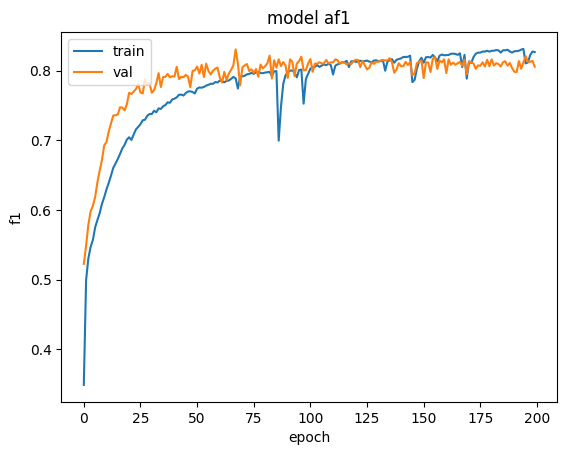

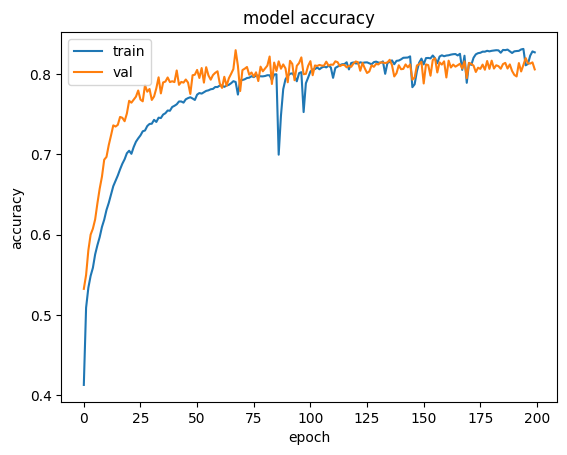

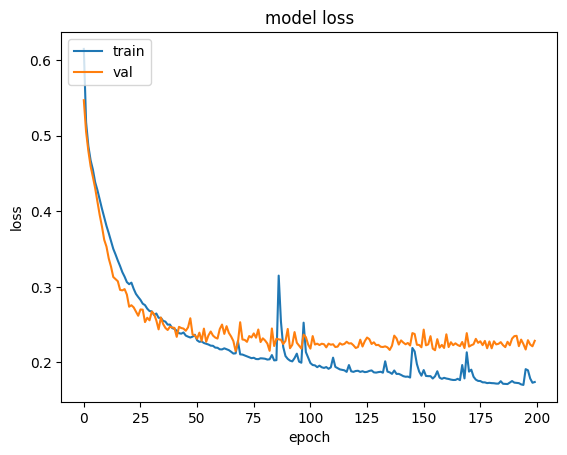

None


In [31]:
print(print_hist(history))

In [32]:
model.save('balanced_textblob_model_best_256.keras')
model.save('balanced_textblob_model_best_256.h5')

/home/g6401201087/Python/myvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
